In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from utils_func import *
from dataset import S3dis
from data_aug import *
from data_aug_tensor import *
import fps_cuda
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
class PointSetAbstractionLayer(nn.Module):
    def __init__(self, stride, radius, k, in_channels, mlp_units):
        super(PointSetAbstractionLayer, self).__init__()
        self.stride = stride
        self.radius = radius
        self.k = k
        
        mlp = [nn.Conv2d(in_channels, mlp_units[0], kernel_size=1),
                    nn.BatchNorm2d(mlp_units[0]),
                    nn.ReLU(inplace=True)]
        for i in range(len(mlp_units) - 1):
            mlp += [nn.Conv2d(mlp_units[i], mlp_units[i + 1], kernel_size=1),
                    nn.BatchNorm2d(mlp_units[i + 1]),
                    nn.ReLU(inplace=True)]

        self.mlp = nn.Sequential(*mlp)
    
    @torch.no_grad()
    def fps(self, points):
        """
        points.shape = (b, n, 3)
        return indices.shape = (b, self.nsamples)
        """
        b, n, _ = points.shape
        device = points.device
        dis = torch.ones((b, n), device=device) * 1e10
        indices = torch.zeros((b, self.nsamples), device=device, dtype=torch.long)

        fps_cuda.fps(points, dis, indices)
        return indices
    
    @torch.no_grad()
    def index_gts(self, gts, indices):
        """
        gts.shape = (b, n)
        indices.shape = (b, self.nsamples)
        return res.shape = (b, self.nsamples)
        """
        device = gts.device
        b = gts.shape[0]

        batch_indices = torch.arange(b, device=device).view(b, 1).expand(-1, self.nsamples)
        res = gts[batch_indices, indices]

        return res
    
    def group(self, points, features, centroids):
        """
        points.shape = (b, n, 3)
        features.shape = (b, n, c)
        centroids.shape = (b, self.nsamples, 3)
        return res.shape = (b, self.nsamples, k, 3+c)
        """
        group_points, group_point_features, _ = my_ball_query(self.radius, self.k, centroids, points, features)
        
        group_points = group_points - centroids.unsqueeze(dim=2)   # 要的是相对坐标

        res = torch.cat((group_points / self.radius, group_point_features), dim=-1)
        return res

    def forward(self, points, features, gts=None):
        """
        points.shape = (b, n, 3)   坐标信息
        features.shape = (b, n, c)   特征信息
        gts.shape = (b, n)
        return centroids.shape = (b, self.nsamples, 3)
        return group_features.shape = (b, self.nsamples, c')
        return gts.shape = (b, self.nsamples)
        """
        self.nsamples = points.shape[1] // self.stride

        fps_indices = self.fps(points[:, :, 0:3])

        centroids = index_points(points, fps_indices)
        if gts is not None:
            gts = self.index_gts(gts, fps_indices)

        group_features = self.group(points[:, :, 0:3], features, centroids[:, :, 0:3])
        group_features = group_features.permute(0, 3, 2, 1)

        group_features, _ = self.mlp(group_features).max(dim=2)
        group_features = group_features.transpose(1, 2)

        return centroids, group_features, gts


class PointFeaturePropagationLayer(nn.Module):
    def __init__(self, in_channels, mlp_units):
        super(PointFeaturePropagationLayer, self).__init__()
        mlp = [nn.Conv1d(in_channels, mlp_units[0], kernel_size=1),
                    nn.BatchNorm1d(mlp_units[0]),
                    nn.ReLU(inplace=True)]
        for i in range(len(mlp_units) - 1):
            mlp += [nn.Conv1d(mlp_units[i], mlp_units[i + 1], kernel_size=1),
                    nn.BatchNorm1d(mlp_units[i + 1]),
                    nn.ReLU(inplace=True)]

        self.mlp = nn.Sequential(*mlp)
    
    def forward(self, points_1, features_1, points_2, features_2):
        """
        points_1来自于更前面层的输出, 点更多
        points_1.shape = (b, n1, 3)
        features_1.shape = (b, n1, c1)
        points_2.shape = (b, n2, 3)
        features_2.shape = (b, n2, c2)
        return final_features.shape = (b, n1, c')
        """
        _, n1, _ = points_1.shape
        _, n2, _ = points_2.shape

        if n2 == 1:
            receive_features = features_2.expand(-1, n1, -1)
        else:
            _, correspond_features, distance = my_knn_query(3, points_1, points_2, features_2)

            dist_recip = 1/ (distance + 1e-8)
            norm_term = dist_recip.sum(dim=-1, keepdim=True)
            weights = dist_recip / norm_term

            receive_features = torch.sum(weights.unsqueeze(dim=3) * correspond_features, dim=2)
        
        final_features = torch.cat((receive_features, features_1), dim=-1)
        final_features = final_features.permute(0, 2, 1)

        final_features = self.mlp(final_features).transpose(1, 2)

        return final_features


class Memory(nn.Module):
    def __init__(self, num_class, length, store_channels, query_channels, num_heads, miu=0.99):
        super(Memory, self).__init__()
        self.num_class = num_class
        self.length = length
        self.store_channels = store_channels
        self.query_channles = query_channels
        self.miu = miu
        self.register_buffer('memory', torch.zeros((num_class, length, store_channels)))
        self.mha = nn.MultiheadAttention(query_channels, num_heads, kdim=store_channels, vdim=store_channels)
        self.cur_occupy = [0] * num_class
        
        self.contrast_mlp = nn.Linear(self.query_channles, self.store_channels)
        
        self.dropout = nn.Dropout(0.1)
        self.mlp = nn.Sequential(nn.Conv1d(query_channels, query_channels*4, 1),
                                 nn.ReLU(True),
                                 nn.Dropout(0.1),
                                 nn.Conv1d(query_channels*4, query_channels, 1),
                                 nn.Dropout(0.1))
        
        self.norm1 = nn.BatchNorm1d(self.query_channles)
        self.norm2 = nn.BatchNorm1d(self.query_channles)
    
    def is_full(self):
        res = True
        for i in range(self.num_class):
            res = (res and (self.cur_occupy[i] == self.length))
        return res
    
    @torch.no_grad()
    def update(self, features, gts):
        """
        features.shape = (b, n, store_channels)
        gts.shape = (b, n)
        """
        for i in range(self.num_class):
            mask = (gts == i)
            cur_features = features[mask]
            if len(cur_features) != 0 :   # 如果存在该类的feature
                choice = torch.randint(0, len(cur_features), (self.length,))
                if self.cur_occupy[i] != self.length:   # 该类的memory未满
                    self.memory[i] = cur_features[choice]
                    self.cur_occupy[i] += self.length
                else:
                    self.memory[i] = cur_features[choice] * (1 - self.miu) + self.memory[i] * self.miu
    
    def forward(self, features, gts=None):
        """
        features.shape = (b, n, query_channels)
        return res.shape = (b, n, query_channels)
        """
        b = features.shape[0]
        contrast_loss = 0
        if self.training and (not self.is_full()):
            print('not full')
            return features, contrast_loss

        if gts is not None:
            temp = self.memory.mean(dim=1)
            contrast_scores = torch.matmul(self.contrast_mlp(features), temp.T)
            contrast_loss = F.cross_entropy(contrast_scores.transpose(1, 2), gts)
        
        features = features.transpose(1, 2)
        memory_features = self.memory.view(-1, self.store_channels).unsqueeze(dim=1).expand(-1, b, -1)
        reve_features, _ = self.mha(features.permute(2, 0, 1), memory_features, memory_features, need_weights=False)

        res = features + self.dropout(reve_features.permute(1, 2, 0))
        res = res + self.mlp(self.norm2(res))
        
        # 求attn_map
        features = features.squeeze().transpose(0, 1)
        k = self.memory.flatten(0, 1).transpose(0, 1)
        attn_map = torch.mm(features, k)
        attn_map = attn_map.softmax(dim=-1)
        
        return res.transpose(1, 2), contrast_loss, attn_map


class Memorynet(nn.Module):
    def __init__(self, class_num):
        super(Memorynet, self).__init__()
        self.in_linear = nn.Linear(7, 32)
        self.sa1 = PointSetAbstractionLayer(4, 0.1, 32, 32+3, [32, 32, 64])
        self.sa2 = PointSetAbstractionLayer(4, 0.2, 32, 64+3, [64, 64, 128])
        self.memory2 = Memory(class_num, 128, 128, 128, 2, 0.9)   # 不同的模型这里要改容量
        self.sa3 = PointSetAbstractionLayer(4, 0.4, 32, 128+3, [128, 128, 256])
        self.memory3 = Memory(class_num, 128, 256, 256, 4, 0.9)
        self.sa4 = PointSetAbstractionLayer(4, 0.8, 32, 256+3, [256, 256, 512])

        self.fp1 = PointFeaturePropagationLayer(512+256, [256, 256])
        self.fp2 = PointFeaturePropagationLayer(256+128, [128, 128])
        self.fp3 = PointFeaturePropagationLayer(128+64, [64, 64])
        self.fp4 = PointFeaturePropagationLayer(64+32, [32, 32])

        self.mlp = nn.Sequential(nn.Conv1d(32, 32, kernel_size=1),
                                 nn.BatchNorm1d(32),
                                 nn.ReLU(inplace=True),
                                 nn.Conv1d(32, 32, kernel_size=1),
                                 nn.BatchNorm1d(32),
                                 nn.ReLU(inplace=True),
                                 nn.Conv1d(32, class_num, kernel_size=1))

    def forward(self, pos, normal, x, gts=None):
        """
        pos.shape = (b, n, 3)
        normal.shape = (b, n, 3)
        x.shape = (b, n, 3)
        """
        features = torch.cat((pos[:, :, -1:], normal, x), dim=-1)
        features = self.in_linear(features)

        points_layer1, features_layer1, gts1 = self.sa1(pos, features, gts)
        points_layer2, features_layer2, gts2 = self.sa2(points_layer1, features_layer1, gts1)
        if self.training:
            self.memory2.update(features_layer2, gts2)
        points_layer3, features_layer3, gts3 = self.sa3(points_layer2, features_layer2, gts2)
        if self.training:
            self.memory3.update(features_layer3, gts3)
        points_layer4, features_layer4, _ = self.sa4(points_layer3, features_layer3)

        features_layer3 = self.fp1(points_layer3, features_layer3, points_layer4, features_layer4)
        features_layer3, contrast_loss1, attn_map = self.memory3(features_layer3, gts3)
        features_layer2 = self.fp2(points_layer2, features_layer2, points_layer3, features_layer3)
        features_layer2, contrast_loss2, _ = self.memory2(features_layer2, gts2)
        features_layer1 = self.fp3(points_layer1, features_layer1, points_layer2, features_layer2)
        features = self.fp4(pos, features, points_layer1, features_layer1)

        y_pred = self.mlp(features.transpose(1, 2))
        contrast_loss = contrast_loss1 + contrast_loss2

        return y_pred, contrast_loss, attn_map

<AxesSubplot: >

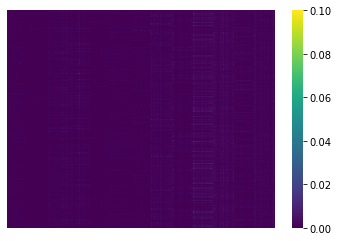

In [10]:
val_aug = Compose([PointCloudFloorCentering(),
                        ColorNormalize()])
val_dataset = S3dis('/home/lindi/chenhr/threed/data/processed_s3dis', split='val', loop=1, transforms=val_aug)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)

device = 'cuda:5'
model = Memorynet(13).to(device)
model_path = '/home/lindi/chenhr/threed/pointnet++/seg/memorynet_seg_v4_128mem.pth'
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()

val_dataloader = iter(val_dataloader)
temp = 1
for i in range(temp):
    pos, x, y = next(val_dataloader)
pos = pos.to(device)
x = x.to(device)
y = y.to(device)
normal = get_normal(pos, 32).to(device)

with torch.no_grad():
    y_pred, _, attn_map = model(pos, normal, x)   # attn_map在cuda上

attn_map = attn_map.to(device='cpu').numpy()

sns.heatmap(attn_map, cmap='viridis', xticklabels=False, yticklabels=False, vmin=0, vmax=0.1)